In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from func import link_maker
from alg import astar,min_conflict,bfs
import matplotlib.pyplot as plt

In [3]:
size = 8

# init_playfield = [-1, 1, -1, -1] 
# init_playfield = [1, -1, 2, 0] 
init_playfield = [-1, 0, -1, -1, -1, -1, -1, -1] 
# init_playfield = [1, 5, 3, 4, 6, 2, 7, 0]

In [4]:
ap, b = astar(size, init_playfield, 100)
print(ap, b)
link_maker(ap)

[5, 3, 0, 4, 7, 1, 6, 2] 93


'https://lichess.org/editor/2Q5/5Q2/7Q/1Q6/3Q4/Q7/6Q1/4Q3_w_-_-_0_1?color=white'

In [ ]:
from tqdm import tqdm
a_s = []
a2_s = []
mc_s = []
for _ in tqdm(range(1000)):
    init_playfield = list(np.random.randint(0, size, size))
    a_playfield, a_breaker = astar(size, init_playfield, 100)
    # a2_playfield, a2_breaker = astar(size, init_playfield, 100, kflag = True)
    mc_playfield, mc_breaker = min_conflict(init_playfield, size, 100)
    a_s.append(a_breaker)
    # a2_s.append(a2_breaker)
    mc_s.append(mc_breaker)
# print(link_maker(a_playfield) if a_breaker <= 100 else "\n")
# print(link_maker(mc_playfield) if mc_breaker <= 100 else "\n")

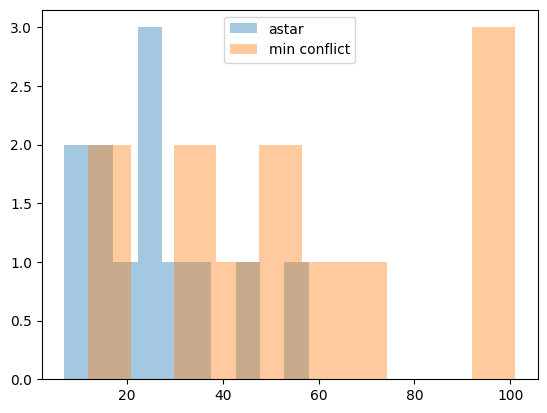

In [6]:
plt.hist(a_s, alpha = 0.4, label = "astar")
plt.hist(mc_s, alpha = 0.4, label = "min conflict")
plt.legend()
plt.show()

In [7]:
pf = bfs(8, True)
link_maker(pf)

found [0, 6, 4, 7, 1, 3, 5, 2]


'https://lichess.org/editor/Q7/4Q3/7Q/5Q2/2Q5/6Q1/1Q6/3Q4_w_-_-_0_1?color=white'